In [1]:
# import packages
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

# For reading files and directories
import os

# Reading images into numpy arrays
from PIL import Image

# splitting, training, and testing
import sklearn.model_selection as ms

# Visualization
import sklearn.metrics as skm

# Eigenfaces and SVM
from sklearn.decomposition import PCA
from sklearn.svm import SVC

%matplotlib inline

Import all images and convert to 3D numpy arrays. Then parse information for each image into dicts.

In [12]:
# create list to hold numpy arrays for each image
images = []
dirname = "./colorferet/front_thumbnails/"
for filename in sorted(os.listdir(dirname)):
    #print(filename)
    im = Image.open(os.path.join(dirname, filename)).convert("RGB") # "L" means b/w. comment out for color
    images.append(np.asarray(im, dtype=np.uint8))

X = np.array(images)
n_samples = X.shape[0]
height = X.shape[1]
width = X.shape[2]
print(height)
print(width)
X = X.reshape([1364,-1])
print(X.shape)


192
128
(1364, 73728)


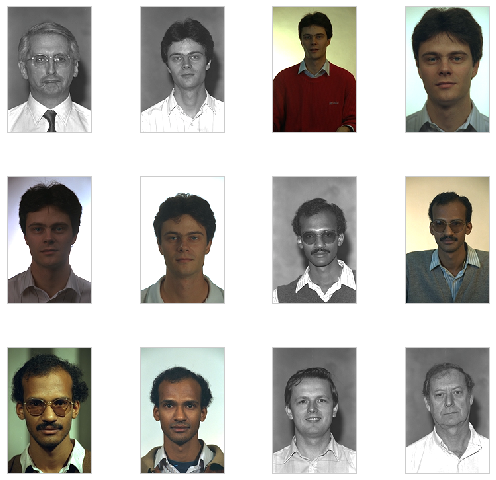

In [16]:
def plot_gallery(images, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X[0:12], height, width)

In [17]:
# create list of dictionaries for each image's attributes
imData = [{} for _ in range(n_samples)]

dirname = "./colorferet/truths/"
filenames = sorted(os.listdir(dirname))
for i in range(n_samples):
    filename = filenames[i]
    textfile = open(os.path.join(dirname, filename))
    for str in textfile.read().split('\n'):
        if len(str) > 0:
            key, value = str.split('=')
        imData[i][key] = value
    textfile.close()

imData[0]

{'beard': 'No',
 'capture_date': '08/31/1993',
 'capture_time': '00:00:00',
 'collection': 'cfrC00001',
 'compression': 'bzip2',
 'disc': '1',
 'environment': 'cfrE00001',
 'expression': 'fa',
 'format': 'ppm',
 'glasses': 'Yes',
 'illuminant': 'cfrI00001 cfrI00002 cfrI00003',
 'left_eye_coordinates': '326 332',
 'mouth_coordinates': '266 468',
 'mustache': 'No',
 'nose_coordinates': '268 404',
 'pitch': '0',
 'pose': 'fa',
 'recording': 'cfrR00002',
 'relative': 'data/images/00001/00001_930831_fa_a.ppm.bz2',
 'right_eye_coordinates': '202 334',
 'roll': '0',
 'sensor': 'cfrN00002',
 'stage': 'cfrT00001',
 'subject': 'cfrS00001',
 'weather': 'inside',
 'yaw': '0'}

Let's train a classifier to look for a mustache, glasses, or beard

In [18]:
y = []
for i in range(n_samples):
    y.append(imData[i]['mustache'])
#    y.append(imData[i]['glasses'])
#    y.append(imData[i]['beard'])
y = pd.Series(y).replace(['No','Yes'],[0,1]).as_matrix()
y[:20]

# split into training and testing sets
X_train, X_test, y_train, y_test = ms.train_test_split(X,y,train_size=0.8)

Extracting the top 200 eigenfaces from 1091 faces
Projecting the input data on the eigenfaces orthonormal basis


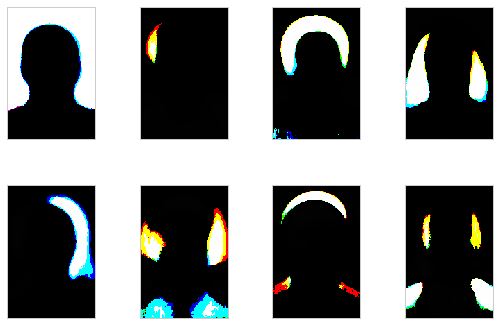

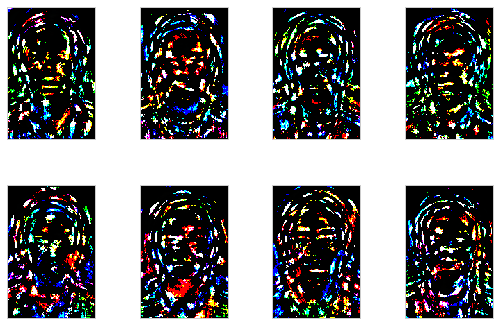

In [38]:
n_components = 200

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape([n_components, height, width, 3])

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# plot them creepy pictures
plot_gallery(eigenfaces[:8], height, width, 2, 4)
plot_gallery(eigenfaces[-8:], height, width, 2, 4)

In [25]:
# create bootstrapped sample set to be added to training set
def pseudoDataFunc(Xinput,Yinput):
    posImages = Xinput[Yinput.astype(bool)]
    negImages = Xinput[~Yinput.astype(bool)]
    print("Number of images with target: {}".format(posImages.shape[0]))
    print("Number of images without target: {}".format(negImages.shape[0]))

    diff = negImages.shape[0]-posImages.shape[0]
    print("Number of new target samples needed: {}".format(diff))

    # Vector of random indices to select new images of mustaches
    indices = np.random.randint(0, high=posImages.shape[0], size=diff)

    pseudoDataList = []
    for i in range(len(indices)):
        pseudoDataList.append(posImages[indices[i]])

    return np.array(pseudoDataList)

# concatenate pseudoData onto training sets
pseudoX = pseudoDataFunc(X_train_pca, y_train)
pseudoX_train_pca = np.concatenate((X_train_pca, pseudoX), axis=0)
pseudoY_train = np.concatenate((y_train, np.ones(len(pseudoX))), axis=0)

Number of images with target: 111
Number of images without target: 980
Number of new target samples needed: 869


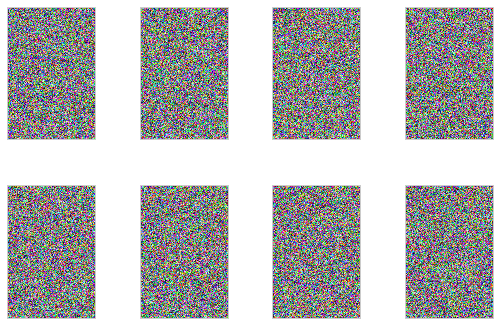

In [29]:
ImBack = pca.inverse_transform(pseudoX)
plot_gallery(ImBack[:8], height, width, 2, 4)
# print(pseudoData.shape)
# print(sum(pseudoY_train)/len(pseudoY_train))


In [30]:
print("Fitting the classifier to the training set")
param_grid = {'C': [1e1, 1e2, 1e3, 1e4],
              'gamma': [0.0005, 0.001, 0.005, 0.01, 0.1]}
clf = ms.GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(pseudoX_train_pca, pseudoY_train)

print("Best estimator found by grid search:")
clf.best_estimator_

Fitting the classifier to the training set
Best estimator found by grid search:


SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
y_pred = clf.predict(X_test_pca)
print(y_pred)
print(skm.classification_report(y_test, y_pred, target_names=['No', 'Yes']))

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

In [41]:
y_score = clf.score(X_test_pca, y_test)
print(y_score)

precision, recall, thresholds = skm.precision_recall_curve(y_test, y_pred, pos_label=1)

print("Precision: \t{}".format(precision))
print("Recall: \t{}".format(recall))
print("Thresholds: \t{}".format(thresholds))

F = 2*(precision[1]*recall[1])/(precision[1]+recall[1])

print("F score: {}".format(F))

0.89010989011
Precision: 	[ 0.10622711  0.          1.        ]
Recall: 	[ 1.  0.  0.]
Thresholds: 	[ 0.  1.]
F score: nan


/home/stu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in double_scalars
